In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 시드 고정
SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# GPU 설정
gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2025-06-18 00:13:05.249553: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-18 00:13:05.344085: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-18 00:13:05.344169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-18 00:13:05.354926: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-18 00:13:05.395406: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
# 경로 설정
IMG_SIZE=224
BATCH_SIZE=32
DATA_PATH="../../data/processed/04_kaggle_dataset"

In [3]:
datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    zoom_range=0.1,
    brightness_range=[0.85, 1.15],
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=False,
    fill_mode="nearest",
    validation_split=0.2
)

train_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode="binary",
    subset="validation",
    shuffle=False,
    seed=SEED
)

Found 8032 images belonging to 2 classes.
Found 2007 images belonging to 2 classes.


In [7]:
# 모델 정의
base_model=MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable=False

model=Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])
MODEL_PATH="../../src/models/23_mobilenetv2/best_model.keras"
os.makedirs(os.path.dirname("../../src/models/23_mobilenetv2"), exist_ok=True)
mcp=ModelCheckpoint(MODEL_PATH, monitor="val_loss", save_best_only=True, verbose=1)
es=EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
reducelr=ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

In [8]:
history=model.fit(train_generator, validation_data=val_generator,
                  epochs=20, callbacks=[es, reducelr, mcp])

Epoch 1/20
251/251 [==============================] - ETA: 0s - loss: 0.5878 - accuracy: 0.7120
Epoch 1: val_loss improved from inf to 0.31630, saving model to ../../src/models/23_mobilenetv2/best_model.keras
251/251 [==============================] - 50s 192ms/step - loss: 0.5878 - accuracy: 0.7120 - val_loss: 0.3163 - val_accuracy: 0.8884 - lr: 1.0000e-04
Epoch 2/20
251/251 [==============================] - ETA: 0s - loss: 0.3162 - accuracy: 0.8704
Epoch 2: val_loss improved from 0.31630 to 0.23867, saving model to ../../src/models/23_mobilenetv2/best_model.keras
251/251 [==============================] - 47s 188ms/step - loss: 0.3162 - accuracy: 0.8704 - val_loss: 0.2387 - val_accuracy: 0.9073 - lr: 1.0000e-04
Epoch 3/20
251/251 [==============================] - ETA: 0s - loss: 0.2774 - accuracy: 0.8904
Epoch 3: val_loss improved from 0.23867 to 0.21068, saving model to ../../src/models/23_mobilenetv2/best_model.keras
251/251 [==============================] - 47s 188ms/step - los

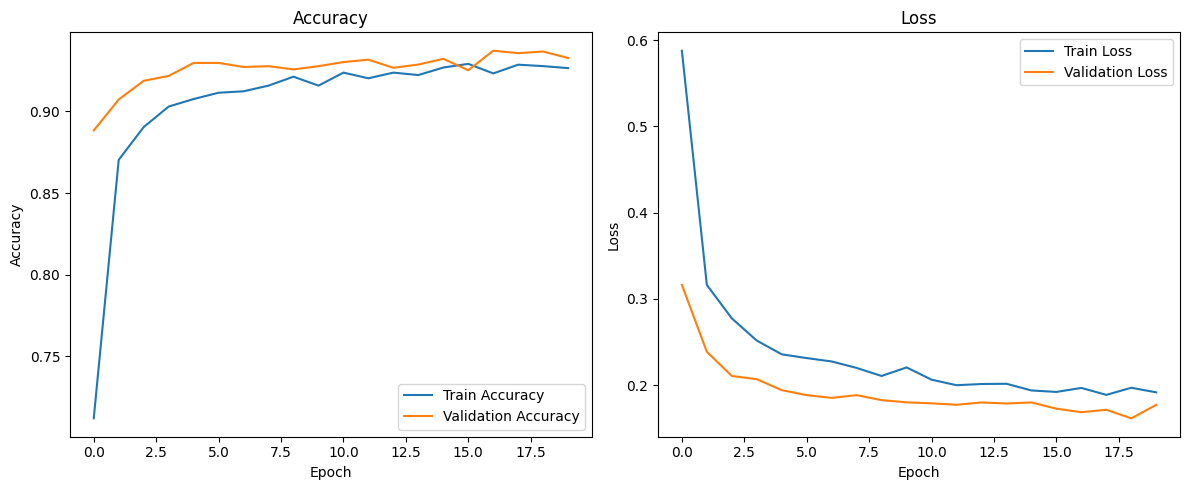

In [ ]:
PLOT_PATH="../../results/images/23_mobilenetv2_training_plot.png"

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig(PLOT_PATH)
plt.show()

In [10]:
REPORT_PATH="../../results/reports/23_mobilenetv2_classification_report.txt"

y_true=val_generator.classes
steps=val_generator.samples // val_generator.batch_size + 1
y_pred_prob=model.predict(val_generator, steps=steps, verbose=0)
y_pred=(y_pred_prob > 0.5).astype(int)

report=classification_report(y_true, y_pred, target_names=["Closed", "Opened"])
print("=== Classification Report ===")
print(report)

with open(REPORT_PATH, "w") as f:
    f.write(report)

=== Classification Report ===
              precision    recall  f1-score   support

      Closed       0.93      0.94      0.93      1000
      Opened       0.94      0.92      0.93      1007

    accuracy                           0.93      2007
   macro avg       0.93      0.93      0.93      2007
weighted avg       0.93      0.93      0.93      2007



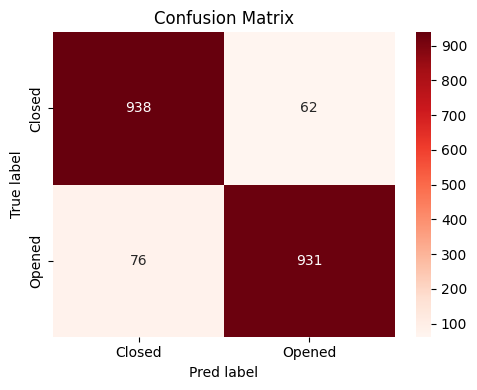

In [11]:
CONFUSION_PATH="../../results/images/23_mobilenetv2_confusion_matrix.png"

conf_matrix=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds",
            xticklabels=["Closed", "Opened"], yticklabels=["Closed", "Opened"])
plt.title("Confusion Matrix")
plt.xlabel("Pred label")
plt.ylabel("True label")
plt.tight_layout()

plt.savefig(CONFUSION_PATH)
plt.show()

In [12]:
#os.makedirs("../../src/models/22_efficientnetb0_addaugment", exist_ok=True)
model.save("../../src/models/23_mobilenetv2/model.keras")